# COVID-19 Prediction of high risk of Fatality

Jiajie Xu, 10Jan2022

# Overview

## Business Problem

It's been two years, but countries around the world are still suffering from the Covid-19 and its varients. We are losing people's life every second. The best way to protect them is vaccination, but the vaccine supply is also influenced by the pandemic. We have got a very urgent priorites to thrash out, which is predicttion of a higher-risk population by using current patient group survey dataset. Thus, we would be able to slow down the death and spread. 

# Data Loading and cleaning

In [2]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels as sm
import sklearn.preprocessing as preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold
from scipy import stats
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, plot_roc_curve, plot_confusion_matrix
from sklearn.datasets import load_iris
# For plotting the tree.
from sklearn.tree import export_graphviz, plot_tree
# from pydotplus import graph_from_dot_data
from IPython.display import Image
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score, confusion_matrix, recall_score, precision_score, accuracy_score
from sklearn import datasets
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors

In [3]:
ls

 Volume in drive D is New Volume
 Volume Serial Number is C649-A6AD

 Directory of D:\Flatiron\Project3

01/11/2022  11:53 PM    <DIR>          .
12/11/2021  05:55 PM    <DIR>          ..
01/10/2022  05:43 AM    <DIR>          .ipynb_checkpoints
01/09/2022  08:27 PM            81,806 Catalogs.xlsx
12/11/2021  05:56 PM        46,684,628 covid.csv
01/09/2022  08:26 PM            14,571 Description.xlsx
01/11/2022  11:53 PM           241,758 project3.ipynb
               4 File(s)     47,022,763 bytes
               3 Dir(s)  1,564,199,444,480 bytes free


In [4]:
df = pd.read_csv('covid.csv')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 566602 entries, 0 to 566601
Data columns (total 23 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   id                   566602 non-null  object
 1   sex                  566602 non-null  int64 
 2   patient_type         566602 non-null  int64 
 3   entry_date           566602 non-null  object
 4   date_symptoms        566602 non-null  object
 5   date_died            566602 non-null  object
 6   intubed              566602 non-null  int64 
 7   pneumonia            566602 non-null  int64 
 8   age                  566602 non-null  int64 
 9   pregnancy            566602 non-null  int64 
 10  diabetes             566602 non-null  int64 
 11  copd                 566602 non-null  int64 
 12  asthma               566602 non-null  int64 
 13  inmsupr              566602 non-null  int64 
 14  hypertension         566602 non-null  int64 
 15  other_disease        566602 non-nu

In [6]:
# for c in df.columns:
#     print ("---- %s ---" % c)
#     print (df[c].value_counts())
# df.head()

## entry_date	date_symptoms	date_died

Use Entry_date minus date_symptoms to get the time length for patient covid-19 develop speed.

In [7]:
df['date_symptoms'] = pd.to_datetime(df['date_symptoms'], format='%d-%m-%Y')
df['entry_date'] = pd.to_datetime(df['entry_date'], format='%d-%m-%Y')
df['date_Difference'] = (df['entry_date'] - df['date_symptoms']).dt.days

In [8]:
df.loc[df['date_died'] == '9999-99-99', 'date_died'] = 0

In [9]:
df.loc[df['date_died'] != 0, 'date_died'] = 1

In [10]:
df['date_died'].value_counts(normalize = True)

0    0.936153
1    0.063847
Name: date_died, dtype: float64

In [11]:
df = df.rename(columns={"date_died": "survive"})

In [12]:
df['survive'].value_counts()

0    530426
1     36176
Name: survive, dtype: int64

In [13]:
df['survive'] = df['survive'].astype(int)

## Sex

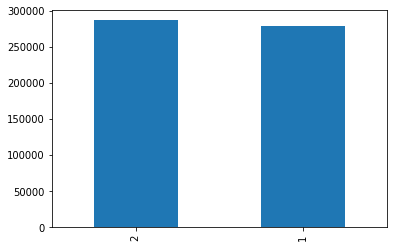

In [14]:
df["sex"].value_counts().plot.bar()
# Docs says that sex == 1 means male, but then some males are pregnant and no females are pregnant. 
# Also, all pregnancy data for sex == 2 is NaN, so it seems that sex should be switched, as opposed to pregnant column.
df.sex = df.sex.replace([1,2], [2, 1])

In [15]:
(df[df['sex'] == 1]['survive'].value_counts()/df[df['sex'] == 1]['survive'].count())*100

0    91.822007
1     8.177993
Name: survive, dtype: float64

In [16]:
(df[df['sex'] == 2]['survive'].value_counts()/df[df['sex'] == 2]['survive'].count())*100

0    95.45744
1     4.54256
Name: survive, dtype: float64

There is a difference between male and female patient, so we will keep this feature.

## Age

Text(22.248996913580257, 0.5, 'count')

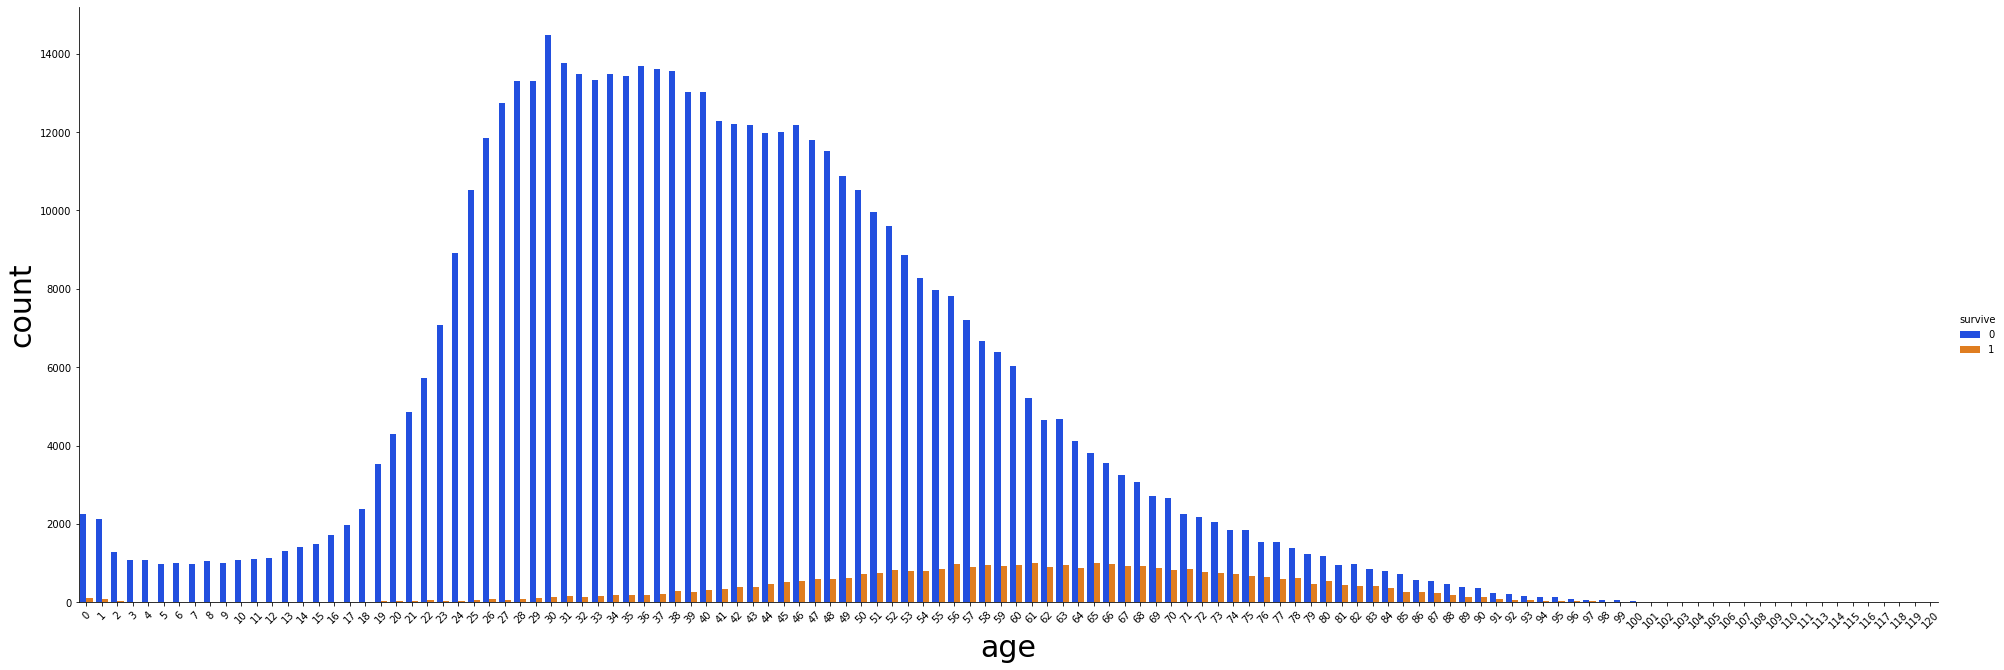

In [17]:
sns.catplot('age',data=df,hue='survive',kind='count',palette='bright',aspect=3,height=9)
plt.xlabel('age',size=30)
plt.xticks(rotation=45)
plt.ylabel('count',size=30)

With the age increasing, death ratio rise. 

## Intubed

change missing value to un-tubed. Here we set intubed as 1, untubed as 0.

In [18]:
df["intubed"].replace({97: 0, 99: 0, 2: 0}, inplace=True)

In [19]:
df['intubed'].value_counts().to_frame()

,intubed
0,556637
1,9965


## Pregnancy

In [20]:
# change missing value to 0, and set original data as binary.
df["pregnancy"].replace({97: 0, 98: 0, 2: 0}, inplace=True)
df['pregnancy'].value_counts().to_frame()

,pregnancy
0,562539
1,4063


## contact_other_covid

In [21]:
df['contact_other_covid'].value_counts()

1     221867
99    175031
2     169704
Name: contact_other_covid, dtype: int64

In [22]:
# This is a catagorical column, we need to change it to three column. 
df["contact_other_covid"].replace({99: 3}, inplace=True)
df = pd.get_dummies(df, columns=['contact_other_covid'])

## ICU

In [23]:
df['icu'].value_counts()
# This is a catagorical column, we need to change it to three column.
# First need to change unspecified value to 3
df["icu"].replace({97: 3, 99: 3}, inplace=True)
# df.info()
# Second need to change feature to 3 columns
df["icu"].replace({99: 3}, inplace=True)
df = pd.get_dummies(df, columns=['icu'])

## Covid_res

In [24]:
df['covid_res'].value_counts()
# This is a catagorical column, we need to change it to three column.
df = pd.get_dummies(df, columns=['covid_res'])

## Remove rest missing value row

In [25]:
# #drop any rows that have missing value in the following columns
df = df[
      (df.pneumonia != 99) &
      (df.diabetes != 98) &
      (df.copd != 98) &
      (df.asthma != 98) &
      (df.inmsupr != 98) &
      (df.hypertension != 98) &
      (df.other_disease != 98) &
      (df.cardiovascular != 98) &
      (df.obesity != 98) &
      (df.renal_chronic != 98) &
      (df.tobacco != 98)]

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 562647 entries, 0 to 566601
Data columns (total 30 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   id                     562647 non-null  object        
 1   sex                    562647 non-null  int64         
 2   patient_type           562647 non-null  int64         
 3   entry_date             562647 non-null  datetime64[ns]
 4   date_symptoms          562647 non-null  datetime64[ns]
 5   survive                562647 non-null  int32         
 6   intubed                562647 non-null  int64         
 7   pneumonia              562647 non-null  int64         
 8   age                    562647 non-null  int64         
 9   pregnancy              562647 non-null  int64         
 10  diabetes               562647 non-null  int64         
 11  copd                   562647 non-null  int64         
 12  asthma                 562647 non-null  int6

## Drop less important value

In [27]:
df = df.drop(['id', 'entry_date', 'date_symptoms'], axis=1)
# df = df.drop(['id', 'entry_date', 'date_symptoms', 'other_disease' , 'icu', 'cardiovascular', 'copd', 'renal_chronic', 'inmsupr', 'asthma', 'pregnancy', 'patient_type'], axis=1)


In [28]:
# Base on the later feature importance, we want to drop column importance less than 2 in order to reduce the calculation cost.
df = df.drop([
"cardiovascular", 
"copd", 
"renal_chronic", 
"inmsupr", 
"asthma", 
"icu_1", 
"icu_2", 
"contact_other_covid_2", 
"contact_other_covid_1", 
"covid_res_2", 
"covid_res_3", 
"pregnancy", 
"icu_3",
"other_disease"],
axis=1)

In [29]:
# df.info()

In [30]:
df.isna().sum() 

sex                      0
patient_type             0
survive                  0
intubed                  0
pneumonia                0
age                      0
diabetes                 0
hypertension             0
obesity                  0
tobacco                  0
date_Difference          0
contact_other_covid_3    0
covid_res_1              0
dtype: int64

Text(0.5, 1.0, 'Correlation heatmap')

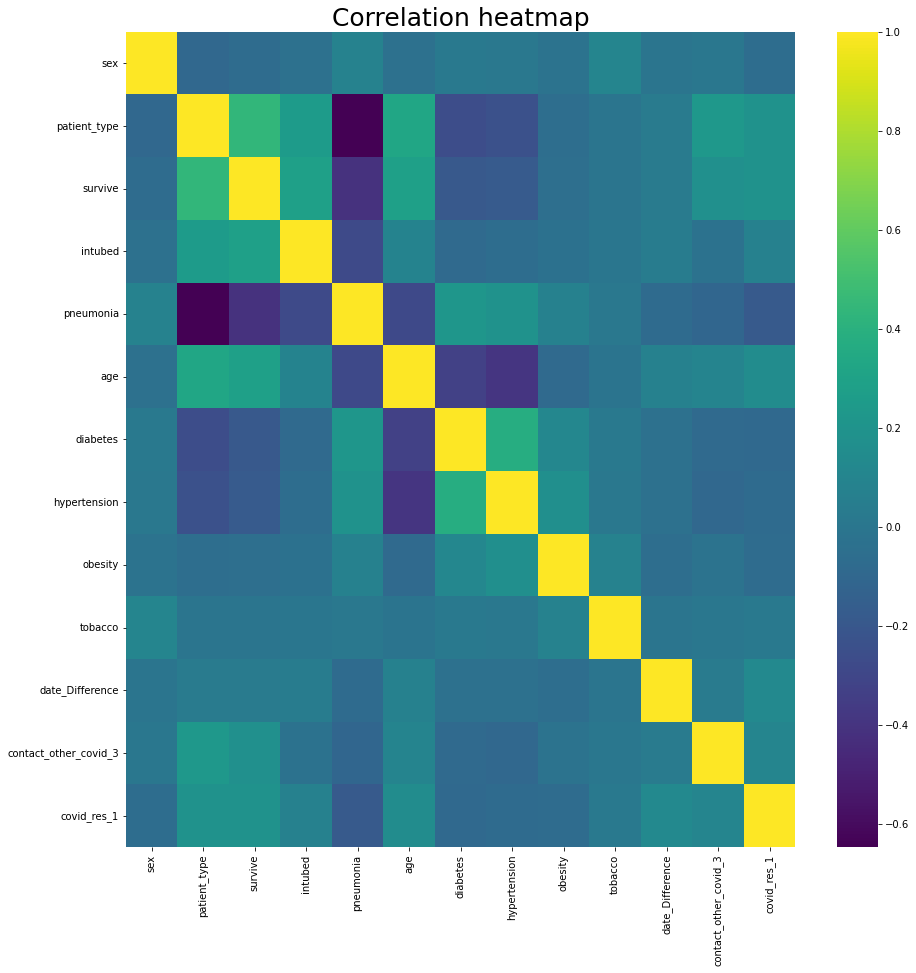

In [31]:
plt.figure(figsize=(15,15))
sns.heatmap(df.corr(),cmap='viridis')
plt.title('Correlation heatmap',size=25)

In [37]:
# change value (1,2) to (0,1), set original data as binary.
df["patient_type"].replace({2: 0}, inplace=True)
df["pneumonia"].replace({1:0, 2: 1}, inplace=True)
df["diabetes"].replace({1:0, 2: 1}, inplace=True)
df["hypertension"].replace({1:0, 2: 1}, inplace=True)
df["obesity"].replace({1:0, 2: 1}, inplace=True)
df["tobacco"].replace({1:0, 2: 1}, inplace=True)
df["patient_type"].replace({2: 0}, inplace=True)
# df['patient_type'].value_counts().to_frame()

In [38]:
for c in df.columns:
    print ("---- %s ---" % c)
    print (df[c].value_counts())
df.head()

---- sex ---
1    284820
2    277827
Name: sex, dtype: int64
---- patient_type ---
1    442343
0    120304
Name: patient_type, dtype: int64
---- survive ---
0    527057
1     35590
Name: survive, dtype: int64
---- intubed ---
0    553020
1      9627
Name: intubed, dtype: int64
---- pneumonia ---
0    562647
Name: pneumonia, dtype: int64
---- age ---
30     14536
31     13847
36     13835
37     13772
38     13751
       ...  
118        1
115        1
117        1
116        1
105        1
Name: age, Length: 120, dtype: int64
---- diabetes ---
1    492328
0     70319
Name: diabetes, dtype: int64
---- hypertension ---
1    470744
0     91903
Name: hypertension, dtype: int64
---- obesity ---
1    471029
0     91618
Name: obesity, dtype: int64
---- tobacco ---
1    514907
0     47740
Name: tobacco, dtype: int64
---- date_Difference ---
0      89940
3      79673
2      78057
1      69256
4      65524
       ...  
65         1
58         1
60         1
61         1
115        1
Name: date_D

,sex,patient_type,survive,intubed,pneumonia,age,diabetes,hypertension,obesity,tobacco,date_Difference,contact_other_covid_3,covid_res_1
0,1,1,0,0,0,27,1,1,1,1,2,0,1
1,1,1,0,0,0,24,1,1,1,1,2,1,1
2,2,0,0,0,0,54,1,1,0,1,5,1,1
3,1,0,0,0,0,30,1,1,1,1,7,1,1
4,2,0,1,0,0,60,0,0,1,1,0,1,1


# Training the model using different algorithms

## Data split into train set and test set

In [32]:
y = df['survive']
X = df.drop(['survive'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state=0)

In [33]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(421985, 12) (140662, 12) (421985,) (140662,)


In [34]:
acc=[]

In [35]:
f1=[]

In [36]:
recall=[]

In [37]:
precision=[]

In [38]:
avg=[]

## Logistic Regression Model

### Train the Model

In [39]:
logreg = LogisticRegression(random_state = 20, class_weight = 'balanced')

In [40]:
logreg.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', random_state=20)

### Predictions and Evaluation
Now that we have a model, lets take a look at how it performs. 

In [41]:
y_hat_test = logreg.predict(X_test)
y_hat_train = logreg.predict(X_train)
print(classification_report(y_train, y_hat_train))

              precision    recall  f1-score   support

           0       0.99      0.87      0.93    395293
           1       0.32      0.91      0.47     26692

    accuracy                           0.87    421985
   macro avg       0.66      0.89      0.70    421985
weighted avg       0.95      0.87      0.90    421985



In [42]:
print(classification_report(y_test, y_hat_test))

              precision    recall  f1-score   support

           0       0.99      0.87      0.93    131764
           1       0.32      0.91      0.48      8898

    accuracy                           0.87    140662
   macro avg       0.66      0.89      0.70    140662
weighted avg       0.95      0.87      0.90    140662



In [43]:
score_accuracy = accuracy_score(y_test,y_hat_test)
score_f1 = f1_score(y_test, y_hat_test)
score_recall = recall_score(y_test, y_hat_test)
score_precision = precision_score(y_test, y_hat_test)
score = (score_f1+score_accuracy)/2
acc.append(score_accuracy)
f1.append(score_f1)
recall.append(score_recall)
precision.append(score_precision)
avg.append(score)
# print('Test Accuracy Score', score)

##  Naive_bayes Model

### Train the Model

In [45]:
gnb = GaussianNB()
gnb.fit(X_train, y_train) 

GaussianNB()

### Predictions and Evaluation

In [46]:
yhat = gnb.predict(X_test)
gnb_score=metrics.accuracy_score(y_test, yhat)
print("GNB's Accuracy:{0}".format(metrics.accuracy_score(y_test, yhat)))

GNB's Accuracy:0.9036342437900784


In [47]:
score_accuracy = accuracy_score(y_test,yhat)
score_f1 = f1_score(y_test, yhat)
score_recall = recall_score(y_test, yhat)
score_precision = precision_score(y_test, yhat)
score = (score_f1+score_accuracy)/2
acc.append(score_accuracy)
f1.append(score_f1)
recall.append(score_recall)
precision.append(score_precision)
avg.append(score)

Text(0.5, 1.0, 'Naive Bayes Metrics')

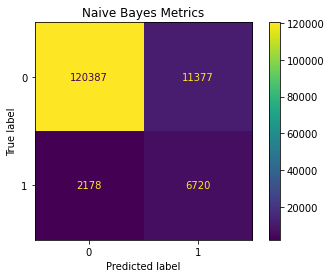

In [80]:
plot_confusion_matrix(gnb, X_test, y_test)
plt.title("Naive Bayes Metrics")

##  KNN Model

### Train the Model

In [49]:
%%time
# list = [5, 10, 15, 20]
# by testingfferent k, we find 15 provide better result
list1 = [5]
for i in list1:
    
    neigh=KNeighborsClassifier(n_neighbors = i, n_jobs= -1).fit(X_train, y_train)
    yhat = neigh.predict(X_test)
    KNN_score=metrics.accuracy_score(y_test, yhat)
    print("Train set Accuracy at {} is {}  ".format(i,metrics.accuracy_score(y_train, neigh.predict(X_train))))
    print("Test set Accuracy at {} is {}".format(i,KNN_score))
    print("\n")

Train set Accuracy at 5 is 0.952401151699705  
Test set Accuracy at 5 is 0.9367277587408113


Wall time: 19.6 s


### Predictions and Evaluation

at n_neighbours=12 we are getting max train and test accuracy i.e, 78% and 75% respectively.

In [50]:
score_accuracy = accuracy_score(y_test,yhat)
score_f1 = f1_score(y_test, yhat)
score_recall = recall_score(y_test, yhat)
score_precision = precision_score(y_test, yhat)
score = (score_f1+score_accuracy)/2
acc.append(score_accuracy)
f1.append(score_f1)
recall.append(score_recall)
precision.append(score_precision)
avg.append(score)

##  Decision Tree model with Grid Search

### Train the Model

In [51]:
dt = DecisionTreeClassifier()
#min_sample_leaf, the most common stopping procedure is to use a minimum count on the number on the number of training instances assigned to each leaf node.
dt.fit(X_train, y_train)

DecisionTreeClassifier()

### Predictions and Evaluation

In [52]:
y_pred = dt.predict(X_test)
y_pred

array([0, 0, 0, ..., 1, 0, 0])

In [53]:
dt_score = accuracy_score(y_test, y_pred)
print("Accuracy: {0}".format(dt_score))

Accuracy: 0.9298815600517553


### Introduce Grid Search to the Decosion Tree

In [54]:
from sklearn.model_selection import GridSearchCV

param_grid= {
    'criterion': ['gini', 'entropy'],
    'max_depth': [1, 5, 10, 20, 30],
    'min_samples_split': [1, 5, 10, 20, 40, 100]
}


grid_search_dt = GridSearchCV(dt, param_grid, scoring = 'f1', n_jobs = -1, cv = 3)
grid_search_dt.fit(X_train, y_train)
grid_search_dt.best_params_

{'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 100}

In [55]:
y_pred = grid_search_dt.predict(X_test)

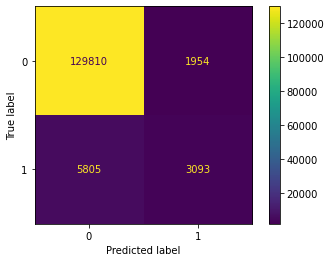

In [56]:
plot_confusion_matrix(grid_search_dt, X_test, y_test)

In [57]:
score_accuracy = accuracy_score(y_test,y_pred)
score_f1 = f1_score(y_test, y_pred)
score_recall = recall_score(y_test, y_pred)
score_precision = precision_score(y_test, y_pred)
score = (score_f1+score_accuracy)/2
acc.append(score_accuracy)
f1.append(score_f1)
recall.append(score_recall)
precision.append(score_precision)
avg.append(score)

### Feature Importances

In [58]:
# let's create a dictionary of features and their importance values
feat_dict= {}
for col, val in sorted(zip(X_train.columns, dt.feature_importances_),key=lambda x:x[1],reverse=True):
  feat_dict[col]=val

In [59]:
feat_df = pd.DataFrame({'Feature':feat_dict.keys(),'Importance':feat_dict.values()})

In [60]:
feat_df

,Feature,Importance
0,patient_type,0.262392
1,age,0.247194
2,date_Difference,0.162815
3,covid_res_1,0.054136
4,hypertension,0.044811
5,intubed,0.038368
6,contact_other_covid_3,0.036398
7,obesity,0.035247
8,diabetes,0.034189
9,pneumonia,0.032891


##  SVM

### Train the Model

Running cost 10 mins, record result below

In [61]:
%%time
from sklearnex import patch_sklearn 
patch_sklearn()
from sklearn import svm
supvm = svm.SVC(kernel='rbf')
supvm.fit(X_train, y_train)

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


Wall time: 1min 24s


SVC()

### Predictions and Evaluation

In [62]:
yhat = supvm.predict(X_test)
svm_score=metrics.accuracy_score(y_test, yhat)
print("SVM's Accuracy:{0}".format(metrics.accuracy_score(y_test, yhat)))

SVM's Accuracy:0.9400193371344073


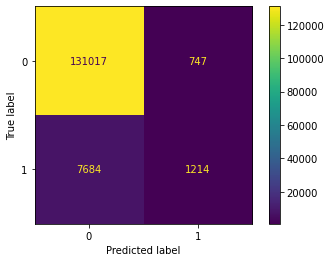

In [63]:
plot_confusion_matrix(supvm, X_test, y_test)

Result: SVM's Accuracy:0.741962324435865

In [64]:
score_accuracy = accuracy_score(y_test,yhat)
score_f1 = f1_score(y_test, yhat)
score_recall = recall_score(y_test, yhat)
score_precision = precision_score(y_test, yhat)
score = (score_f1+score_accuracy)/2
acc.append(score_accuracy)
f1.append(score_f1)
recall.append(score_recall)
precision.append(score_precision)
avg.append(score)

## Random Forest Classifier

### Train the Model

In [66]:
from sklearn.ensemble import RandomForestClassifier
Random_forest = RandomForestClassifier(n_estimators=50)
Random_forest.fit(X_train,y_train)

RandomForestClassifier(n_estimators=50)

### Predictions and Evaluation

In [67]:
randomForest_predict = Random_forest.predict(X_test)
randomForest_score = metrics.accuracy_score(y_test, randomForest_predict)
print("Random Forest Score :",randomForest_score)

Random Forest Score : 0.9385548335726778


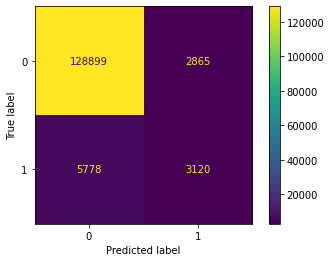

In [68]:
plot_confusion_matrix(Random_forest, X_test, y_test)

In [69]:
score_accuracy = accuracy_score(y_test,randomForest_predict )
score_f1 = f1_score(y_test, randomForest_predict )
score_recall = recall_score(y_test, randomForest_predict )
score_precision = precision_score(y_test, randomForest_predict )
score = (score_f1+score_accuracy)/2
acc.append(score_accuracy)
f1.append(score_f1)
recall.append(score_recall)
precision.append(score_precision)
avg.append(score)

## Gradient Boosting

### Train the Model

In [70]:
gbk = GradientBoostingClassifier(random_state=100, n_estimators=150,min_samples_split=100, max_depth=6)
gbk.fit(X_train, y_train)

GradientBoostingClassifier(max_depth=6, min_samples_split=100, n_estimators=150,
                           random_state=100)

### Predictions and Evaluation

In [71]:
gbk_predict = gbk.predict(X_test)
gbk_score = gbk.score(X_test,y_test)
#print("Gradient Boosting Prediction :",gbk_predict)
print("Gradient Boosting Score :",gbk_score)

Gradient Boosting Score : 0.9449176039015512


<Figure size 1440x1440 with 0 Axes>

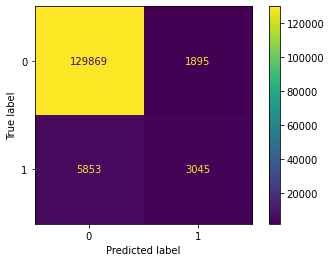

In [72]:
plt.figure(figsize=(20,20))
plot_confusion_matrix(gbk, X_test, y_test)

In [73]:
score_accuracy = accuracy_score(y_test,gbk_predict)
score_f1 = f1_score(y_test, gbk_predict)
score_recall = recall_score(y_test, gbk_predict)
score_precision = precision_score(y_test, gbk_predict)
score = (score_f1+score_accuracy)/2
acc.append(score_accuracy)
f1.append(score_f1)
recall.append(score_recall)
precision.append(score_precision)
avg.append(score)

In [74]:
algo_name = ['Logistic Regression','Naive Bayes','KNN','Decision Tree','SVM','Random Forest','Gradient Boosting']
acc=np.array(acc)
result = pd.DataFrame(list(zip(algo_name, acc, f1, recall, precision,avg)),columns =['algo_name', 'acc', 'f1', 'recall', 'precision', 'avg'])
result = result.sort_values('avg')

In [79]:
result

,algo_name,acc,f1,recall,precision,avg
4,SVM,0.940019,0.222611,0.135761,0.617903,0.581315
2,KNN,0.936728,0.370669,0.294561,0.499809,0.653698
0,Logistic Regression,0.873100,0.476079,0.911441,0.322183,0.674589
5,Random Forest,0.938555,0.419270,0.350641,0.521303,0.678913
6,Gradient Boosting,0.944918,0.440092,0.342212,0.616397,0.692505
3,Decision Tree,0.944839,0.443600,0.347606,0.612839,0.694220
1,Naive Bayes,0.903634,0.497870,0.755226,0.371332,0.700752


Text(0, 0.5, 'avg')

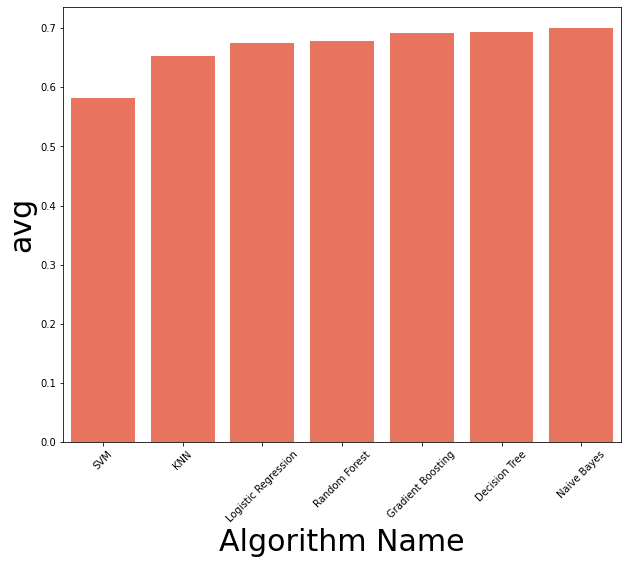

In [78]:
from numpy import median
plt.figure(figsize=(10,8))
sns.barplot(y='avg', x='algo_name', estimator=median, color='tomato', data = result)
plt.xlabel('Algorithm Name',size=30)
plt.xticks(rotation=45)
plt.ylabel('avg',size=30)

# Conclusion

1. After comparing different models, my team conclude that Naive Bayes provide best accuracy among these models. Accuracy is 0.90, f1 score is 0.50.​

2. Feature Importance indicate that we need to vaccinate elder hospitality patient especially disease developing fast patient, cause they are most vulnerable group. ​

3. People with disease such as obesity, diabetes, pneumonia and smoke history have higher death ratio, we need to serve those person as priority as well.

# Future work

1. With bigger dataset and more features included, we would be able to generate a better model with higher accuracy.
2. As the vaccination been given to the population, we may able to trace the efficiency along the time and also reply it to different group of people.
3. Some model really cost long time to have result, I want to adjust it or find better mathine learning model to fit the columns. 